In [1]:
# mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [24]:
import tensorflow as tf
import numpy as np
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Dropout, Bidirectional, Input, dot, Activation, TimeDistributed, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
import keras
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import nltk
import io
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata

# plot japanese lang
!pip install japanize-matplotlib
import japanize_matplotlib
!pip install keras-multi-head
from keras_multi_head import MultiHead
# ignore warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# load text file

**this dataset is aleady implemented a SentenceSpace**

In [0]:
num_example = 5000

# create each languages list
def create_lang_list(num_example):
    # load txt file
    lines =  io.open("/content/drive/My Drive/Colab Notebooks/raw.txt", encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[w for w in l.split('\t')]  for l in lines[:num_example]]

    return zip(*word_pairs)

In [0]:
en, ja = create_lang_list(num_example)

In [0]:
# use other dataset
en = io.open("/content/drive/My Drive/OpenSubtitles2016.en-ja.en", encoding="utf-8").read().strip().split("\n")
ja = io.open("/content/drive/My Drive/OpenSubtitles2016.en-ja.ja", encoding="utf-8").read().strip().split("\n")
en = en[:30000]
ja = ja[:30000]

In [5]:
# sentencepiece
!pip install sentencepiece
import sentencepiece as spm
spm_model = spm.SentencePieceProcessor()
spm_model. load("/content/drive/My Drive/wiki-ja.model")

True

In [0]:
  ja = [" ".join(spm_model.encode_as_pieces(i)).replace("▁", "") for i in ja]

# Text Pre-processing

**Removing accented characters** 

e.g. é → e.

**Expanding Contractions** 

e.g. don't → do not, I'd → I would

**remove special word** 

e.g. remove "123#@"

**Stemming**

 e.g. corder, codes → code

**Lemmatization**

 e.g. better → good

**Tokenize**

 e.g. I am going to restaurant → [[I], [am], [going], [to], [restaurant]]

# Removing accented characters

English might have accent like é but Japanese doesn't have any accent I just create different function to ascii for Japanese and English

In [0]:
# Removing accented characters
def english_unicode_to_ascii(text):
     return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

def japanese_unicode_to_ascii(text):
    return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text))

In [7]:
# e.g.
japanese_unicode_to_ascii("こんにちは。今日は"), english_unicode_to_ascii("Hello world é ")

('こんにちは。今日は', 'Hello world e ')

# Expanding Contractions
Japanese doesn't have a Contraction words so I just create a one function to expand Contractions for Engish

In [0]:
def expand_constraction(text):

    #  dic for expand constraction words
    constraction_dict= {
        "ain't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    #  define match pattern
    #  IGNORECASE → no matter if word is lowercase or uppercase
    #  DOTAIL → . is going to match \n
    contraction_pattern = re.compile('({})'.format('|'.join(constraction_dict.keys())),
                                                  flags=re.IGNORECASE | re.DOTALL)
    #  expand words
    def expand_match(constraction):
        # get constraction word
        match = constraction.group(0)
        first_char = match[0]
        #  get expand word from constraction dict
        expand_constraction = constraction_dict.get(match)\
                                                    if constraction_dict.get(match) \
                                                    else constraction_dict.get(match.lower())
        
        # create expand constraction
        expand_constraction = first_char + expand_constraction[1:]
        return expand_constraction
    
    expanded_text = contraction_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [8]:
# e.g.
expand_constraction("you're good I'd like to go he's she's")

'you are good I would like to go he is she is'

# remove special characters and create space between word and punctuation

replacing everything with space except(a-z, A-Z, "?", "!", "-", "ー", "Kanji", "Katakana", "Hiragana") 
create space between word and punctuation (? ! )

In [0]:
def replace_special_character_to_space(text):
    pattern = r"[^a-zA-Z\u3041-\u309F\u30A1-\u30FF\uFF66-\uFF9F\u4E00-\u9FD0\u309B\u3099\uFF9E\u309C\u309A\uFF9F?!\-/\s]+"
    text = re.sub(pattern, '', text).rstrip().strip()
    text = text.replace("・" , "")

    text = re.sub(r"([?!.,。、])", r" \1 ", text)
    text = text.lower()

    return text

In [10]:
# e.g.
replace_special_character_to_space("hello, . #@…123world."), replace_special_character_to_space("こん・にちは。・ いい天気。")

('hello  world', 'こんにちは いい天気')

# Stemming and Lemmatization
I will do stemming only english which can create a base form of a word from a given word. Japanese language doesn't need a stemming

In [0]:
def stemmer_word(text):
    ps = nltk.stem.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [12]:
# e.g.
stemmer_word("hello world she has cat but he had dogs he is went to traveling")

'hello world she ha cat but he had dog he is went to travel'

# Normalize each word

In [0]:
def normalize_english(english_text, japanese_text):
    
    input_value = ()
    target_value = ()
    
    for en_text, ja_text in zip(english_text, japanese_text):
        
        # normalize English
        en_text = english_unicode_to_ascii(en_text)
        en_text = expand_constraction(en_text)
        en_text = replace_special_character_to_space(en_text)
        en_text = "<sos> " + en_text + " <eos>"
        
        input_value += (en_text, )

        # normalize Japanese
        ja_text = japanese_unicode_to_ascii(ja_text)
        ja_text = expand_constraction(ja_text)
        ja_text = replace_special_character_to_space(ja_text)

        ja_text = "<sos> " + ja_text + " <eos>"
        
        target_value += (ja_text, )

    return input_value, target_value

# get clean text data

In [0]:
input_value, target_value = normalize_english(en, ja)

In [276]:
input_value[:10], target_value[:10]

(('<sos> the cabinet of dr caligari <eos>',
  '<sos> act <eos>',
  '<sos> spirits surround us on every side - they have driven me from hearth and home from wife and child <eos>',
  '<sos> she is my bride <eos>',
  '<sos> what she and i have experienced is yet more remarkable than the story you have told me <eos>',
  '<sos> i will tell you <eos>',
  '<sos> in the small town where i was born <eos>',
  '<sos> a traveling fair had arrived <eos>',
  '<sos> him <eos>',
  '<sos> my friend alan <eos>'),
 ('<sos> カリ ガリ 博士 の 小屋 <eos>',
  '<sos> 幕 <eos>',
  '<sos> 私は 亡 霊 の おかげで 家族 や 家庭 を捨て ざる を えなかった <eos>',
  '<sos> 僕 の 婚約 者 だ <eos>',
  '<sos> 僕 と 彼女の 体験 は あなた の物語 よりも 恐ろしい <eos>',
  '<sos> 今 から それを 話 して あげ よう <eos>',
  '<sos> 故郷 ハ レ シュ テン バル での 出来事 だ <eos>',
  '<sos> お 祭り が ひら かれた <eos>',
  '<sos> ある 香 具 師 が やってきた <eos>',
  '<sos> 親友 の アラン だ <eos>'))

english length: 56
japanese length: 49


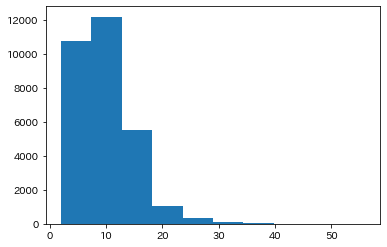

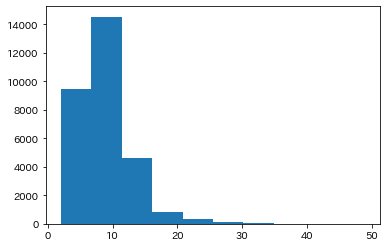

In [13]:
# populate the lists with sentence lengths
english_len = [len(i.split()) for i in input_value]

japanese_len = [len(i.split()) for i in target_value]

plt.figure()
plt.hist(english_len)

plt.figure()
plt.hist(japanese_len)

# print max length
print("english length:", max(english_len))
print("japanese length:", max(japanese_len))

# tokenize
tokenize each language word based on space

In [0]:
# build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# prepare English tokenizer
eng_tokenizer = tokenization(input_value)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

# must all the sequences of the same length.
eng_length = 56
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 11677


In [16]:
# prepare Japanese tokenizer
ja_tokenizer = tokenization(target_value)
ja_vocab_size = len(ja_tokenizer.word_index) + 1

# must all the sequences of the same length.
ja_length = 49
print('japanese Vocabulary Size: %d' % ja_vocab_size)

japanese Vocabulary Size: 11367


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines, padding):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding=padding)
    return seq

# load Word2Vec pre train model
I will use pre-train model for embedding for English and Japanese words

In [83]:
import gensim
import gensim.models.keyedvectors as word2vec

# load pre-trian model for Japanese 
ja_word2vec_model = gensim.models.Word2Vec.load('/content/drive/My Drive/jawiki.doc2vec.dbow300d/jawiki.doc2vec.dbow300d.model')

# load pre-train model for English
en_word2vec_model = word2vec.KeyedVectors.load_word2vec_format("/content/drive/My Drive/GoogleNews-vectors-negative300.bin", binary=True, unicode_errors='ignore')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# similar word with country name
ja_word2vec_model.wv.most_similar("日本")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('アメリカ', 0.6172695159912109),
 ('日本国内', 0.6169887781143188),
 ('米国', 0.5836105346679688),
 ('韓国', 0.583561897277832),
 ('海外', 0.5563584566116333),
 ('アジア', 0.5504777431488037),
 ('中国', 0.5415611863136292),
 ('アジア地域', 0.5271817445755005),
 ('台湾', 0.52516770362854),
 ('アジア諸国', 0.5203936100006104)]

In [0]:
# calculate word and word
ja_word2vec_model.wv.most_similar(positive=["お父さん", "死"], negative=["泣"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('息子', 0.5948961973190308),
 ('お母さん', 0.5658013820648193),
 ('母親', 0.559698760509491),
 ('おばあちゃん', 0.5565805435180664),
 ('父', 0.5533062815666199),
 ('母', 0.5530043840408325),
 ('パパ', 0.5508877635002136),
 ('亡き', 0.5500179529190063),
 ('婚約者', 0.5495285391807556),
 ('死ん', 0.546082615852356)]

In [0]:
# similar word with country name
en_word2vec_model.most_similar("Canada")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Canadian', 0.7513011693954468),
 ('Ontario', 0.6928848028182983),
 ('Nova_Scotia', 0.6792765259742737),
 ('Manitoba', 0.67861008644104),
 ('Alberta', 0.6736730337142944),
 ('Canadians', 0.6654781103134155),
 ('Quebec', 0.6514720320701599),
 ('British_Columbia', 0.6478375196456909),
 ('Peller_Estates_Icewine', 0.6433447003364563),
 ('Saskatchewan', 0.6383945941925049)]

In [0]:
# calculate word and word
en_word2vec_model.most_similar(positive=["programmer", "skill"], negative=["money"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Programmer', 0.4614413380622864),
 ('3D_modeller', 0.4489377737045288),
 ('skils', 0.4471549987792969),
 ('puzzle_solver', 0.4467487633228302),
 ('Jon_Shiring', 0.4382207989692688),
 ('programmers', 0.4363787770271301),
 ('coder', 0.434060662984848),
 ('skills', 0.42342013120651245),
 ('skillset', 0.42207223176956177),
 ('animator', 0.4214385449886322)]

In [0]:
# get weights
# English
input_embedding_matrix = np.zeros((eng_vocab_size, 300))
for word, i in eng_tokenizer.word_index.items():
    if i >= num_example:
        continue
    try:
        input_embedding_matrix[i] = en_word2vec_model.get_vector(word)
    except KeyError:
        continue

# Japanese
target_embedding_matrix = np.zeros((ja_vocab_size, 300))
for word, i in ja_tokenizer.word_index.items():
    if i >= num_example:
        continue
    try:
        target_embedding_matrix[i] = ja_word2vec_model.wv.get_vector(word)
    except KeyError:
        continue

In [108]:
input_embedding_matrix.shape, target_embedding_matrix.shape

((11677, 300), (11367, 300))

# Create train data

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test set
encoder_input_train, encoder_input_test , decoder_input_train, decoder_input_test = train_test_split(input_value, target_value, test_size=0.33, random_state = 42)

In [19]:
len(decoder_input_train)

20100

In [0]:
# remove <sos> token from decoder_input
decoder_output_train = decoder_input_train.copy()
decoder_output_test = decoder_input_test.copy()
# encoder_input_train = [i.replace(" <eos>", "").replace("<sos> ", "") for i in encoder_input_train]
# encoder_input_test = [i.replace(" <eos>", "").replace("<sos> ", "") for i in encoder_input_test]

# decoder_input_train = [i.replace(" <eos>", "") for i in decoder_input_train]
# decoder_input_test = [i.replace(" <eos>", "") for i in decoder_input_test]
# decoder_output_train = [i.replace("<sos> ", "") for i in decoder_output_train]
# decoder_output_test = [i.replace("<sos> ", "") for i in decoder_output_test]

In [285]:
decoder_input_test[:20]

['<sos> 殺人 者は ロジャース の ポケット に  鍵 を 戻 して ベッド に入る <eos>',
 '<sos> 頭 に 手 を置いて ください <eos>',
 '<sos> 似たような も んだ <eos>',
 '<sos> -  奴 は どこ だ  ?  <eos>',
 '<sos> そう 思 って る なら  窓 を 開け なかった ね <eos>',
 '<sos> -  誰 に 聞く んだ  ピート  ?  <eos>',
 '<sos> 芸術家 だ と言って  部屋 を借り ました  彼 も 一 緒 だった <eos>',
 '<sos> 大 丈夫 か  ?  <eos>',
 '<sos> いま 服を着 ます から <eos>',
 '<sos> 元気 になった ら 出 て行く って  ドー ラン から 聞いた わ <eos>',
 '<sos> 相手 は 誰 な の  ?  <eos>',
 '<sos> ゼ ブラ クラブ で 会 おう <eos>',
 '<sos> 質問 された 際に     正しい 答え が  言 える ように <eos>',
 '<sos> 見せ かけ の はず が  真実 になった <eos>',
 '<sos> その <eos>',
 '<sos> 心配 ない <eos>',
 '<sos> -  は い  閣 下 <eos>',
 '<sos> 何 の 希望者 だ  ?  <eos>',
 '<sos> す まない <eos>',
 '<sos> 党 から  同情 してもらう  つもり はない わ <eos>']

In [0]:
# prepare training data
# eng_tokenizer = tokenization(input_value)
X_train = encode_sequences(eng_tokenizer, eng_length, encoder_input_train, "post")
Y_train_input = encode_sequences(ja_tokenizer, ja_length, decoder_input_train, "post")
Y_train_output = encode_sequences(ja_tokenizer, ja_length, decoder_output_train, "post")


# prepare validation data
X_test = encode_sequences(eng_tokenizer, eng_length, encoder_input_test, "post")
Y_test_input = encode_sequences(ja_tokenizer, ja_length, decoder_input_test, "post")

In [22]:
print(X_train.shape)
print(Y_train_input.shape)
print(X_test.shape)
print(Y_test_input.shape)
print(Y_train_output.shape)

(20100, 56)
(20100, 49)
(9900, 56)
(9900, 49)
(20100, 49)


# Model building

In [0]:
# build NMT model
in_vocab = eng_vocab_size
out_vocab = ja_vocab_size
in_timesteps = eng_length
out_timesteps = ja_length
units = 512

# build encoder model
encoder_input = Input(shape=(in_timesteps, ))

# use pre-trained model Word2Vec
encoder_embedding = Embedding(input_dim=in_vocab, output_dim=300)(encoder_input) 
# Dropout
encoder_embedding = Dropout(0.1)(encoder_embedding)

encoder_output, state_h, state_c = LSTM(units, return_sequences=True, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]


# build decoder model
decoder_input = Input(shape=(out_timesteps, ))

# use pre-trained model Word2Vec
decoder_embedding = Embedding(input_dim=out_vocab, output_dim=300)
decoder_emb = decoder_embedding(decoder_input)

# Dropout
decoder = Dropout(0.1)(decoder_emb)

decoder_lstm = LSTM(units, return_sequences=True,)
decoder = decoder_lstm(decoder,  initial_state=encoder_states)


t = Dense(5000, activation='tanh')(decoder)
t2 = Dense(5000, activation='tanh')(encoder_output)
attention = dot([t, t2], axes=[2, 2])

attention = Dense(in_timesteps, activation='tanh')(attention)
attention = Activation('softmax')(attention)

context = dot([attention, encoder_output], axes = [2,1])

decoder_combined_context = keras.layers.concatenate([context, decoder])

decoder_combined_context=Dense(2000, activation='tanh')(decoder_combined_context)
output=(Dense(out_vocab, activation="softmax"))(decoder_combined_context)

model = Model(inputs=[encoder_input, decoder_input], outputs=[output])

In [26]:
# optimize loss function
adam = optimizers.adam(lr=0.001, decay=1e-2)

model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 56)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 56, 300)      3503100     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 49, 300)      3410100     input_4[0][0]                    
__________________________________________________________________________________________

In [27]:
# checkpoint
filename = 'model.h1.22_Nov_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='min')              

# train model
history = model.fit([X_train, Y_train_input], Y_train_output.reshape(Y_train_output.shape[0], Y_train_output.shape[1], 1),
                    epochs=6, batch_size=64, validation_split=0.33 , callbacks=[checkpoint],                    
                    verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 13466 samples, validate on 6634 samples
Epoch 1/6





13466/13466 [==============================] - 67s 5ms/step - loss: 1.2029 - acc: 0.8524 - val_loss: 0.8588 - val_acc: 0.8718
Epoch 2/6
13466/13466 [==============================] - 64s 5ms/step - loss: 0.7761 - acc: 0.8788 - val_loss: 0.6982 - val_acc: 0.8924
Epoch 3/6
13466/13466 [==============================] - 64s 5ms/step - loss: 0.6435 - acc: 0.8954 - val_loss: 0.6136 - val_acc: 0.9017
Epoch 4/6
13466/13466 [==============================] - 64s 5ms/step - loss: 0.5770 - acc: 0.9034 - val_loss: 0.5722 - val_acc: 0.9081
Epoch 5/6
13466/13466 [==============================] - 64s 5ms/step - loss: 0.5354 - acc: 0.9089 - val_loss: 0.5450 - val_acc: 0.9133
Epoch 6/6
13466/13466 [==============================] - 64s 5ms/step - loss: 0.5040 - acc: 0.9133 - val_loss: 0.5232 - val_acc: 0.9167


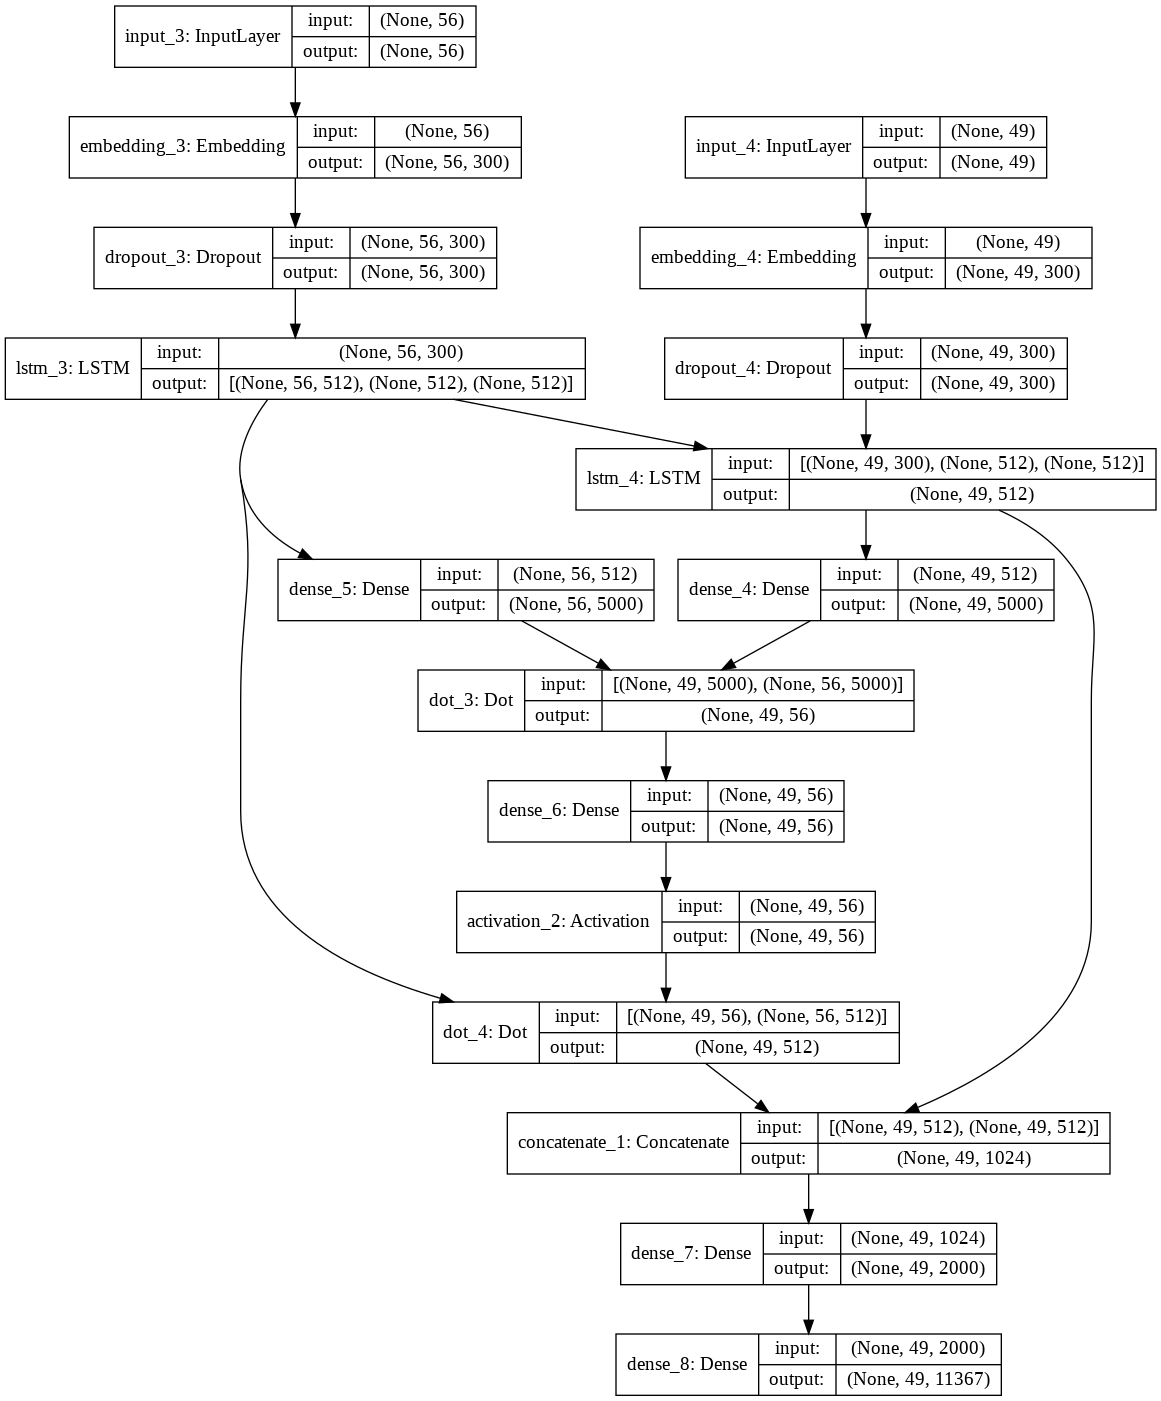

In [28]:
from keras.utils import plot_model

# model plot
plot_model(model, to_file='train-bert.png', show_shapes=True)

In [0]:
#precision
def precision(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20), 'float32'))
    pred_positives = K.sum(K.cast(K.greater(K.clip(y_pred, 0, 1), 0.20), 'float32'))

    precision_v = true_positives / (pred_positives + K.epsilon())
    return precision_v

#recall
def recall(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20), 'float32'))
    poss_positives = K.sum(K.cast(K.greater(K.clip(y_true, 0, 1), 0.20), 'float32'))

    recall_v = true_positives / (poss_positives + K.epsilon())
    return recall_v

#f1 score
def f1_score(y_true, y_pred):
    precision_v = precision(y_true, y_pred)
    recall_v = recall(y_true, y_pred)
    f1_score_v = 2 * precision_v * recall_v / (precision_v + recall_v)

    return f1_score_v


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


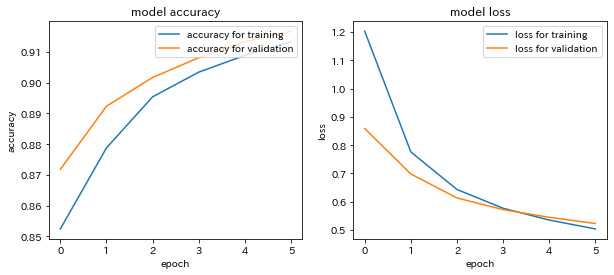

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
print(history.history.keys())
def plot_history_acc(history):
    # plot the accuracy
    ax1.plot(history.history['acc'],label="accuracy for training")
    ax1.plot(history.history['val_acc'],label="accuracy for validation")
    ax1.set_title('model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(loc='upper right')

def plot_history_loss(history):
    # Plot the loss
    ax2.plot(history.history['loss'],label="loss for training")
    ax2.plot(history.history['val_loss'],label="loss for validation")
    ax2.set_title('model loss')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(loc='upper right')

plot_history_loss(history)
plot_history_acc(history)
plt.show()

In [0]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

def plot_history_precision(history):
    # Plot the loss
    ax[0, 0].plot(history.history['precision'],label="precision for training")
    ax[0, 0].plot(history.history['val_precision'],label="precision for validation")
    ax[0, 0].set_title('model precision')
    ax[0, 0].set_xlabel('epoch')
    ax[0, 0].set_ylabel('precision')
    ax[0, 0].legend(loc='upper right')

def plot_history_recall(history):
    # Plot the loss
    ax[0, 1].plot(history.history['recall'],label="recall for training")
    ax[0, 1].plot(history.history['val_recall'],label="recall for validation")
    ax[0, 1].set_title('model recall')
    ax[0, 1].set_xlabel('epoch')
    ax[0, 1].set_ylabel('recall')
    ax[0, 1].legend(loc='upper right')

def plot_history_f1_score(history):
    # Plot the loss
    ax[1, 0].plot(history.history['f1_score'],label="f1_score for training")
    ax[1, 0].plot(history.history['val_f1_score'],label="f1_score for validation")
    ax[1, 0].set_title('model f1_score')
    ax[1, 0].set_xlabel('epoch')
    ax[1, 0].set_ylabel('f1_score')
    ax[1, 0].legend(loc='upper right')

ax[1,1].axis('off')

plot_history_precision(history)
plot_history_recall(history)
plot_history_f1_score(history)

plt.show()

In [0]:
# load model data 
model = load_model('model.h1.22_Nov_19')

In [0]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [0]:
def predict_sequence(model, tokenizer, x, y):
  prediction = model.predict([x, y], verbose=0)[0]
  integers = [argmax(vector) for vector in prediction]
  target = list()
  for i in integers:
    word = word_for_id(i, tokenizer)
    if word is None:
      break
    target.append(word)
  return ' '.join(target)

In [0]:
actual = list()
predicted = list()
for i, (en, ja) in enumerate(zip(X_test[:30], Y_test_input[:30])):
  # translate encoded source text

  en = en.reshape((1, en.shape[0]))
  ja = ja.reshape((1, ja.shape[0]))
  translation = predict_sequence(model, ja_tokenizer, en, ja)

  actual.append([decoder_output_test[i]]) 
  predicted.append(translation)

In [34]:
from nltk.translate.bleu_score import corpus_bleu

# calculate BLEU score
print('BLEU corpus: %f' % corpus_bleu(actual, predicted))
# from nltk.translate.bleu_score import sentence_bleu
# print("BLUE  sentense: %f" % sentence_bleu(actual, predicted))

BLEU corpus: 0.240889


In [35]:
# view actual sentence anf predict result
pred_df = pd.DataFrame({'predicted' : predicted, "actual": actual})
pred_df.head(30)

,predicted,actual
0,sos ありがとう ラン 警察 の 殺 に 待ち を 捜 い 戻 もない eos,[<sos> 殺人 者は ロジャース の ポケット に 鍵 を 戻 して ベッド ...
1,sos まえ に ご らは ください eos,[<sos> 頭 に 手 を置いて ください <eos>]
2,sos 馬車 も んだ eos,[<sos> 似たような も んだ <eos>]
3,sos でも は どこ だ eos,[<sos> - 奴 は どこ だ ? <eos>]
4,sos そう まえ って る なら 乗 を ください った ね eos,[<sos> そう 思 って る なら 窓 を 開け なかった ね <eos>]
5,sos この に 聞き んだ 聞き eos,[<sos> - 誰 に 聞く んだ ピート ? <eos>]
6,sos 処 だ しよう だが 病 ます 我 も 見 きゃ だった eos,[<sos> 芸術家 だ と言って 部屋 を借り ました 彼 も 一 緒 だった <...
7,sos お前 った か eos,[<sos> 大 丈夫 か ? <eos>]
8,sos どういう ガス した から eos,[<sos> いま 服を着 ます から <eos>]
9,sos ありがとう さん ら う もない って 見 ラン から ています わ eos,[<sos> 元気 になった ら 出 て行く って ドー ラン から 聞いた わ <eos>]


# Translation

In [0]:
input_value, _ = normalize_english(["today is good day"], _)
sample_sent = encode_sequences(eng_tokenizer, eng_length, input_value, "post")
sample_sent

In [242]:
encoder_model = Model(encoder_input, encoder_states)
encoder_model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 56)                0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 56, 300)           3503100   
_________________________________________________________________
dropout_37 (Dropout)         (None, 56, 300)           0         
_________________________________________________________________
lstm_33 (LSTM)               [(None, 56, 300), (None,  721200    
Total params: 4,224,300
Trainable params: 4,224,300
Non-trainable params: 0
_________________________________________________________________


In [0]:
def translation(encoder_output):

    decoder_state_h = Input(shape=(300, ))
    decoder_state_c = Input(shape=(300, ))
    decoder_states_inputs = [decoder_state_h, decoder_state_c]
    decoder_emb = decoder_embedding(decoder_input)
    deocder = Dropout(0.1)(decoder_emb)

    decoder_output, statae_h, state_c = decoder_lstm(deocder, initial_state=decoder_states_inputs)
    print("hello2")

    decoder_states = [statae_h, state_c]


    t = Dense(5000, activation='tanh')(decoder_output)
    t2 = Dense(5000, activation='tanh')(encoder_output)
    attention = dot([t, t2], axes=[2, 2])

    attention = Dense(in_timesteps, activation='tanh')(attention)
    attention = Activation('softmax')(attention)

    context = dot([attention, encoder_output], axes = [2,1])

    decoder_combined_context = keras.layers.concatenate([context, decoder])

    decoder_combined_context=Dense(2000, activation='tanh')(decoder_combined_context)
    output=(Dense(out_vocab, activation="softmax"))(decoder_combined_context)
    decoder_model = Model([decoder_input] + decoder_states_inputs, [output] + decoder_states)
    # Reverse-lookup token index to decode sequences back to
    # something readable.
    reverse_input_char_index = dict(
        (i, char) for char, i in eng_tokenizer.items())
    reverse_target_char_index = dict(
        (i, char) for char, i in ja_tokenizer.items())

    return decoder_model, reverse_input_char_index, reverse_target_char_index

In [0]:
def decoder_seq(input_sentence):
    state_value = encoder_model.predict(input_sentence)
    decoder_model, reverse_input_char_index, reverse_target_char_index = translation(state_value)

    target_seq = np.zero((1, 1))
    target_seq[0, 0] = ja_tokenizer.word_index("sos")

    stop_condition = False
    decoder_sentence = ''

    while not stop_condition:
      output_token, state_h, state_c = decoder_model.predict([target_seq] + state_value)

      sample_token_index = np.argmax(output_token[0, -1, :])
      sampled_char = reverse_target_char_index[sample_token_index]
      decoder_sentence += ' '+sampled_char

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == 'eos' or
          len(decoder_sentence) > out_timesteps):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,1))
      target_seq[0, 0] = sample_token_index

      # Update states
      states_value = [h, c]

    return decoded_sentence

In [245]:
print(decoder_seq(sample_sent))

OperatorNotAllowedInGraphError: ignored